# Regresión Lineal Múltiple: Análisis de Residuos y Tratamiento de Outliers e interpretabilidad de coeficientes

En este ejercicio trabajaremos con el dataset de Boston Housing para:

1. **Análisis de residuos**: Evaluación de supuestos de la regresión lineal
2. **Detección de heterocedasticidad**: Pruebas estadísticas y visualizaciones
3. **Evaluación de normalidad**: Pruebas de normalidad en los residuos
4. **Detección de outliers**: Métodos estadísticos y visuales
5. **Transformación de variables**: Normalización, estandarización, escalado Min-Max
6. **Evaluación del impacto**: Comparación de la calidad de residuos antes y después del tratamiento

## Importar las librerías necesarias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from scipy.stats import jarque_bera, shapiro, anderson, normaltest
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.outliers_influence import OLSInfluence
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## Cargar y preparar los datos

In [3]:
# Cargar el dataset
dataset = pd.read_csv('../data/BostonHousing.csv')

# Separar variables predictoras y objetivo
X = dataset.drop('MEDV', axis=1)
y = dataset['MEDV']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensiones del conjunto de entrenamiento: {X_train.shape}")
print(f"Dimensiones del conjunto de prueba: {X_test.shape}")

Dimensiones del conjunto de entrenamiento: (404, 13)
Dimensiones del conjunto de prueba: (102, 13)


## 1. Modelo Base y Análisis de Residuos Inicial

In [4]:
# Crear y entrenar el modelo base
model_base = LinearRegression()
model_base.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = model_base.predict(X_train)
y_pred_test = model_base.predict(X_test)

# Calcular residuos
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

# Métricas del modelo base
mse_base = mean_squared_error(y_test, y_pred_test)
r2_base = r2_score(y_test, y_pred_test)
rmse_base = np.sqrt(mse_base)

print("=== MODELO BASE ===")
print(f"MSE: {mse_base:.3f}")
print(f"RMSE: {rmse_base:.3f}")
print(f"R²: {r2_base:.3f}")
print(f"\nEstadísticas de los residuos:")
print(f"Media: {np.mean(residuals_test):.6f}")
print(f"Desviación estándar: {np.std(residuals_test):.3f}")
print(f"Mínimo: {np.min(residuals_test):.3f}")
print(f"Máximo: {np.max(residuals_test):.3f}")

=== MODELO BASE ===
MSE: 24.291
RMSE: 4.929
R²: 0.669

Estadísticas de los residuos:
Media: 0.235826
Desviación estándar: 4.923
Mínimo: -10.939
Máximo: 25.260


### 1.1 Visualización de Residuos

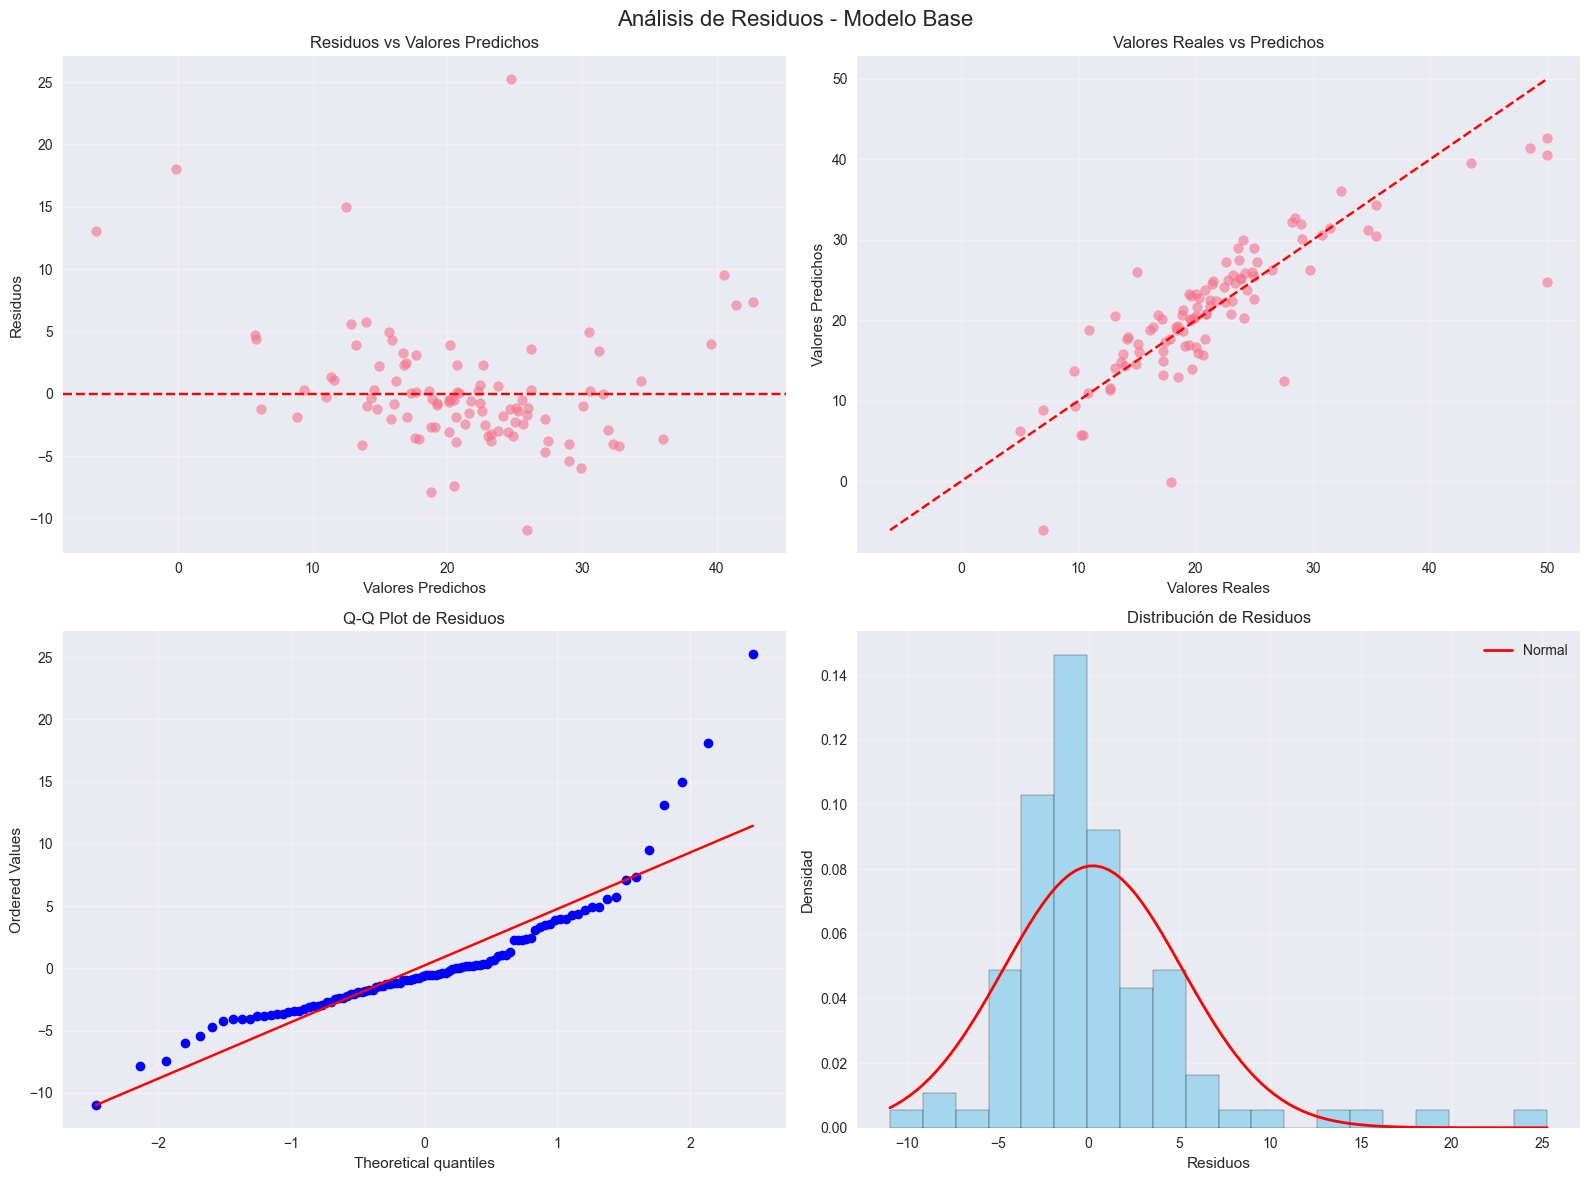

In [5]:
# Crear gráficos de diagnóstico de residuos
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Residuos vs Valores Predichos
ax1.scatter(y_pred_test, residuals_test, alpha=0.6)
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_xlabel('Valores Predichos')
ax1.set_ylabel('Residuos')
ax1.set_title('Residuos vs Valores Predichos')
ax1.grid(True, alpha=0.3)

# 2. Valores Reales vs Predichos
ax2.scatter(y_test, y_pred_test, alpha=0.6)
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'red', linestyle='--')
ax2.set_xlabel('Valores Reales')
ax2.set_ylabel('Valores Predichos')
ax2.set_title('Valores Reales vs Predichos')
ax2.grid(True, alpha=0.3)

# 3. Q-Q Plot de residuos
stats.probplot(residuals_test, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot de Residuos')
ax3.grid(True, alpha=0.3)

# 4. Histograma de residuos
ax4.hist(residuals_test, bins=20, density=True, alpha=0.7, color='skyblue', edgecolor='black')
# Superimponer curva normal
mu, sigma = stats.norm.fit(residuals_test)
x = np.linspace(residuals_test.min(), residuals_test.max(), 100)
ax4.plot(x, stats.norm.pdf(x, mu, sigma), 'red', linewidth=2, label='Normal')
ax4.set_xlabel('Residuos')
ax4.set_ylabel('Densidad')
ax4.set_title('Distribución de Residuos')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Análisis de Residuos - Modelo Base', fontsize=16)
plt.tight_layout()
plt.show()

## 2. Pruebas de Heterocedasticidad

In [6]:
# Preparar datos para pruebas estadísticas
X_train_const = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_const).fit()

print("=== PRUEBAS DE HETEROCEDASTICIDAD ===")

# 1. Prueba de Breusch-Pagan
bp_stat, bp_pvalue, bp_fstat, bp_f_pvalue = het_breuschpagan(model_sm.resid, X_train_const)
print(f"\n1. Prueba de Breusch-Pagan:")
print(f"   Estadístico LM: {bp_stat:.4f}")
print(f"   p-valor: {bp_pvalue:.4f}")
print(f"   Interpretación: {'Hay heterocedasticidad' if bp_pvalue < 0.05 else 'Homocedasticidad (varianza constante)'}")

# 2. Prueba de White
white_stat, white_pvalue, white_fstat, white_f_pvalue = het_white(model_sm.resid, X_train_const)
print(f"\n2. Prueba de White:")
print(f"   Estadístico LM: {white_stat:.4f}")
print(f"   p-valor: {white_pvalue:.4f}")
print(f"   Interpretación: {'Hay heterocedasticidad' if white_pvalue < 0.05 else 'Homocedasticidad (varianza constante)'}")

=== PRUEBAS DE HETEROCEDASTICIDAD ===

1. Prueba de Breusch-Pagan:
   Estadístico LM: 59.1891
   p-valor: 0.0000
   Interpretación: Hay heterocedasticidad

2. Prueba de White:
   Estadístico LM: 305.4927
   p-valor: 0.0000
   Interpretación: Hay heterocedasticidad


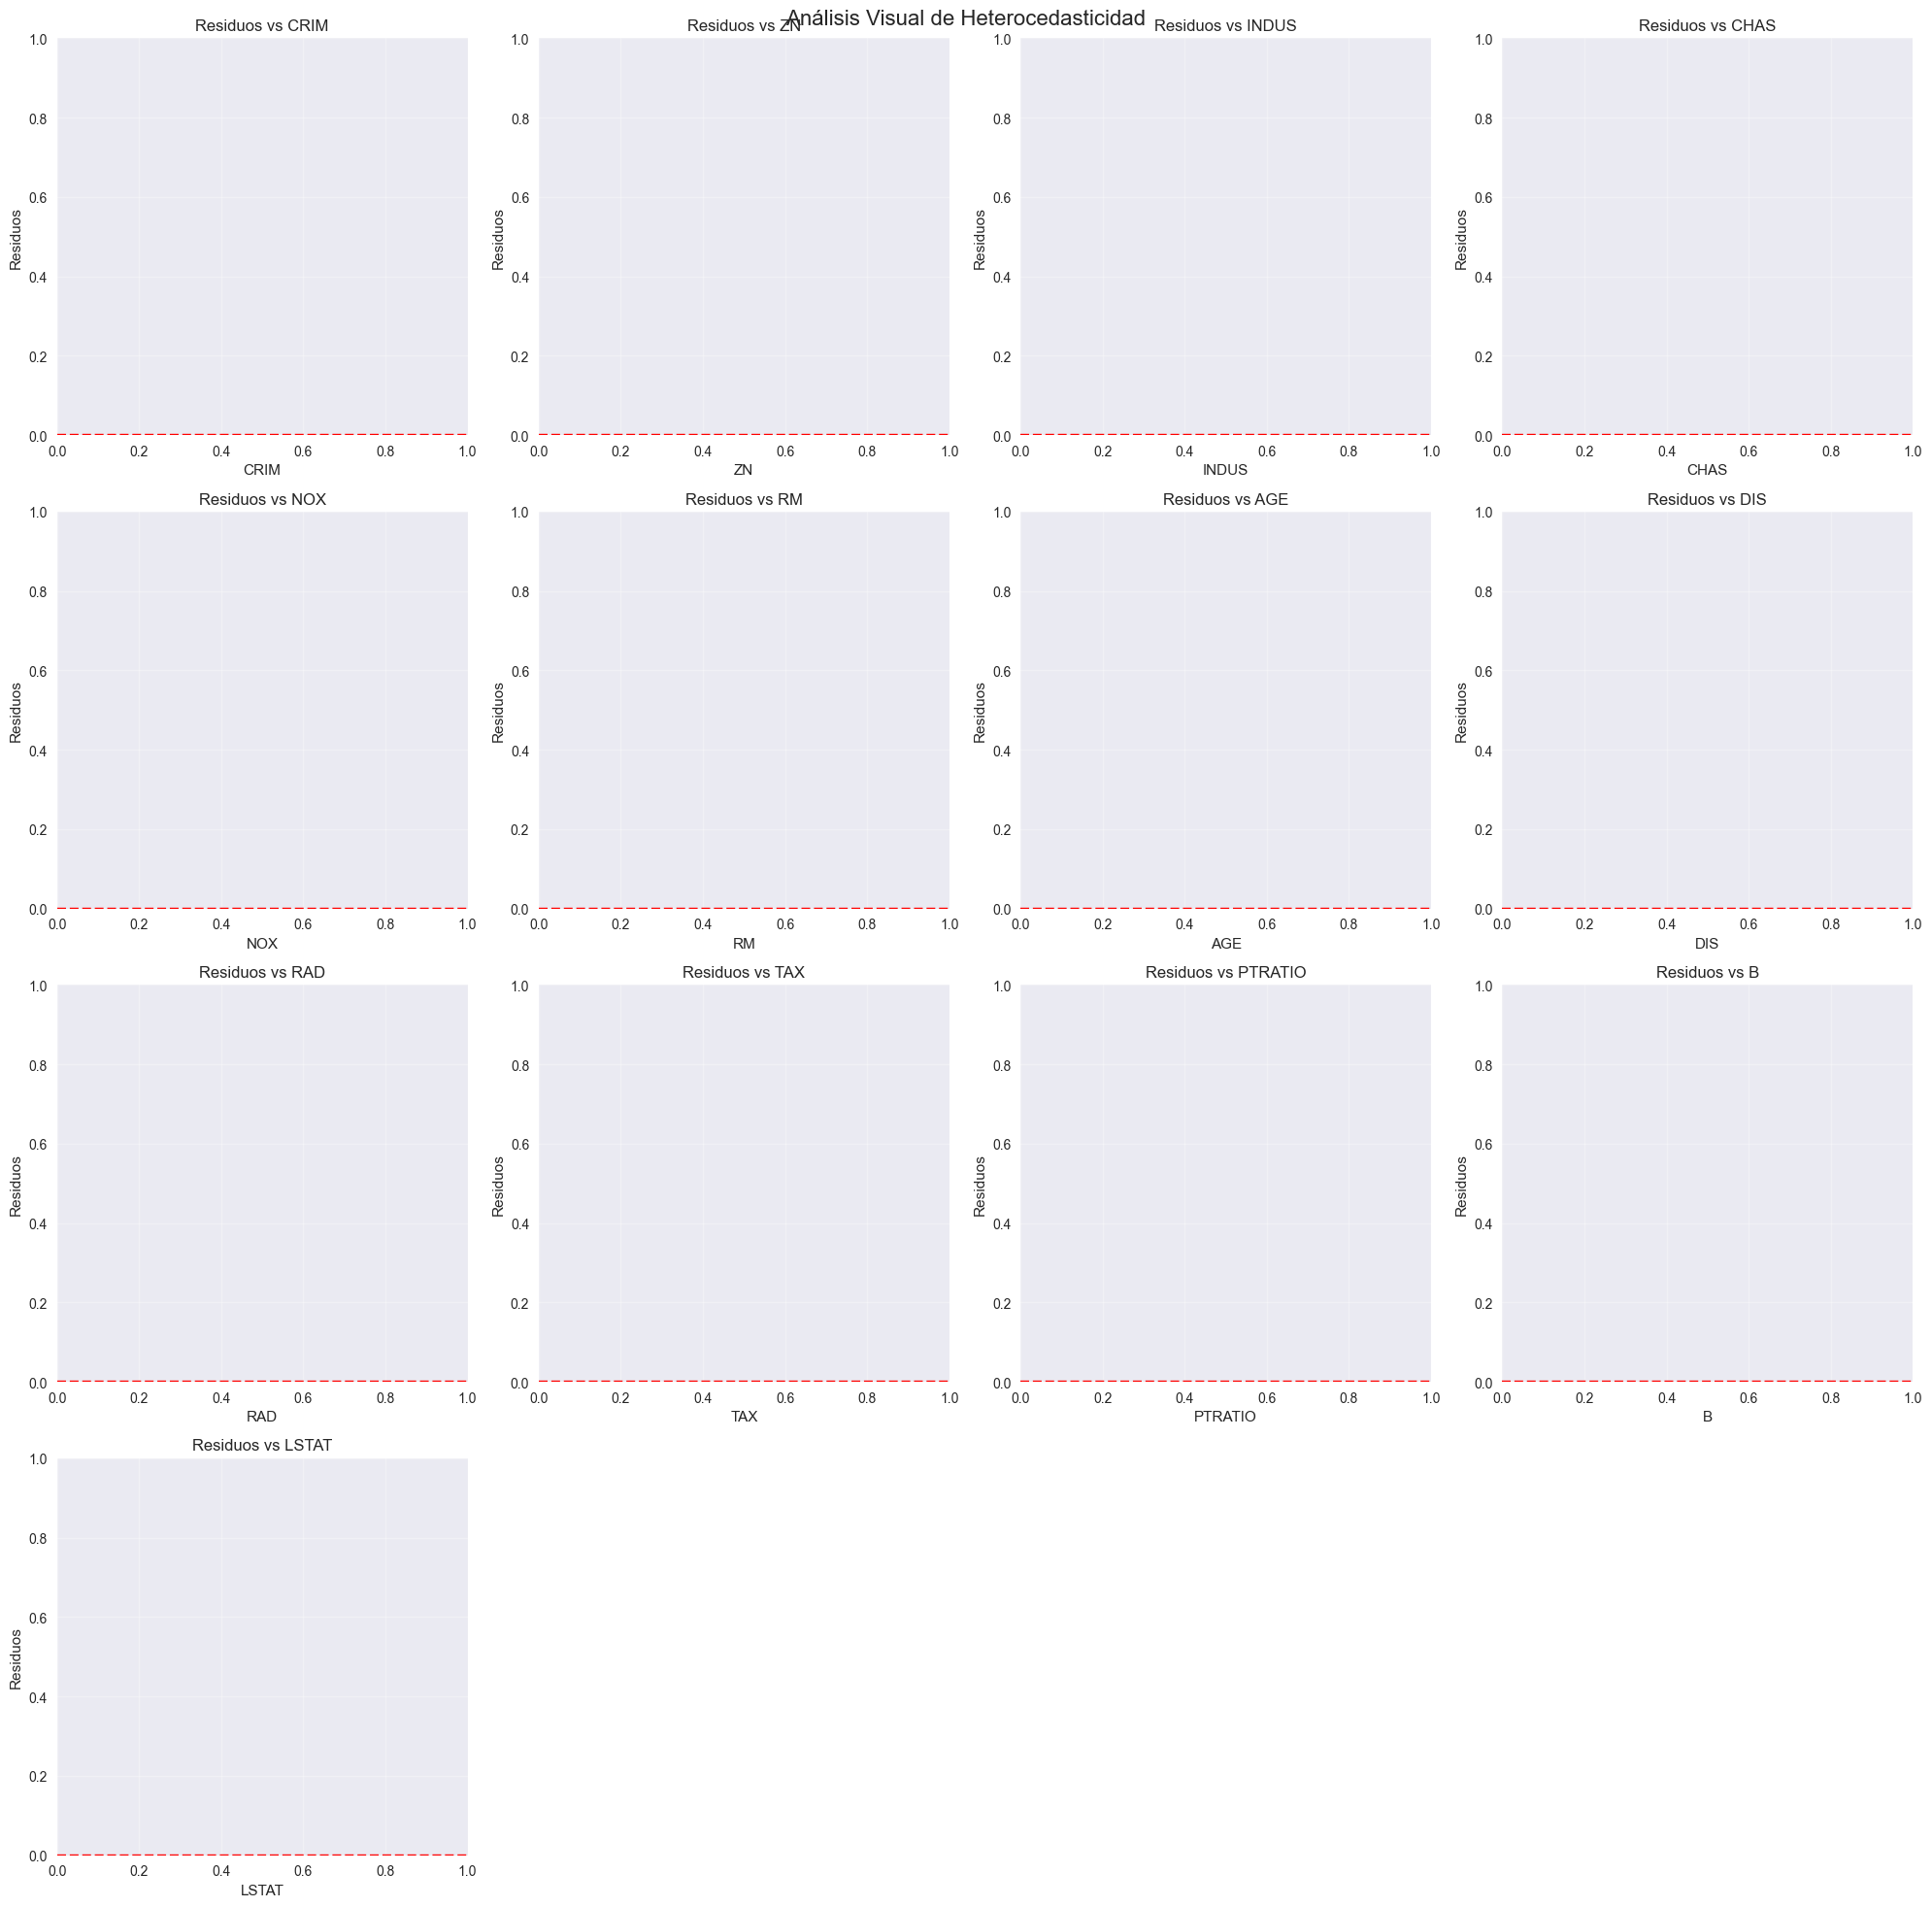

In [7]:
# TODO: Análisis visual de heterocedasticidad
# Sugerencia: Crea gráficos de residuos vs cada variable predictora

# Calcular el número de subplots necesarios
n_features = X_train.shape[1]
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for i, feature in enumerate(X_train.columns):
    # TODO: Crear scatter plot de residuos vs cada variable
    # COMPLETAR: axes[i].scatter(...)
    
    axes[i].axhline(y=0, color='red', linestyle='--')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Residuos')
    axes[i].set_title(f'Residuos vs {feature}')
    axes[i].grid(True, alpha=0.3)

# Ocultar subplots sobrantes
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Análisis Visual de Heterocedasticidad', fontsize=16)
plt.tight_layout()
plt.show()

## 3. Pruebas de Normalidad de Residuos

In [8]:
print("=== PRUEBAS DE NORMALIDAD DE RESIDUOS ===")

# 1. Prueba de Shapiro-Wilk
shapiro_stat, shapiro_pvalue = shapiro(residuals_test)
print(f"\n1. Prueba de Shapiro-Wilk:")
print(f"   Estadístico W: {shapiro_stat:.4f}")
print(f"   p-valor: {shapiro_pvalue:.4f}")
print(f"   Interpretación: {'Los residuos NO son normales' if shapiro_pvalue < 0.05 else 'Los residuos siguen distribución normal'}")

# 2. Prueba de Jarque-Bera
jb_stat, jb_pvalue = jarque_bera(residuals_test)
print(f"\n2. Prueba de Jarque-Bera:")
print(f"   Estadístico JB: {jb_stat:.4f}")
print(f"   p-valor: {jb_pvalue:.4f}")
print(f"   Interpretación: {'Los residuos NO son normales' if jb_pvalue < 0.05 else 'Los residuos siguen distribución normal'}")

# 3. Prueba de D'Agostino
dagostino_stat, dagostino_pvalue = normaltest(residuals_test)
print(f"\n3. Prueba de D'Agostino:")
print(f"   Estadístico: {dagostino_stat:.4f}")
print(f"   p-valor: {dagostino_pvalue:.4f}")
print(f"   Interpretación: {'Los residuos NO son normales' if dagostino_pvalue < 0.05 else 'Los residuos siguen distribución normal'}")

# 4. Prueba de Anderson-Darling
anderson_result = anderson(residuals_test, dist='norm')
print(f"\n4. Prueba de Anderson-Darling:")
print(f"   Estadístico AD: {anderson_result.statistic:.4f}")
print(f"   Valores críticos: {anderson_result.critical_values}")
print(f"   Niveles de significancia: {anderson_result.significance_level}")

# Interpretación de Anderson-Darling
reject_levels = []
for i, cv in enumerate(anderson_result.critical_values):
    if anderson_result.statistic > cv:
        reject_levels.append(anderson_result.significance_level[i])

if reject_levels:
    print(f"   Interpretación: Se rechaza normalidad en niveles: {reject_levels}%")
else:
    print(f"   Interpretación: No se rechaza normalidad en ningún nivel")

=== PRUEBAS DE NORMALIDAD DE RESIDUOS ===

1. Prueba de Shapiro-Wilk:
   Estadístico W: 0.8314
   p-valor: 0.0000
   Interpretación: Los residuos NO son normales

2. Prueba de Jarque-Bera:
   Estadístico JB: 297.3316
   p-valor: 0.0000
   Interpretación: Los residuos NO son normales

3. Prueba de D'Agostino:
   Estadístico: 63.3353
   p-valor: 0.0000
   Interpretación: Los residuos NO son normales

4. Prueba de Anderson-Darling:
   Estadístico AD: 4.2511
   Valores críticos: [0.556 0.633 0.759 0.885 1.053]
   Niveles de significancia: [15.  10.   5.   2.5  1. ]
   Interpretación: Se rechaza normalidad en niveles: [np.float64(15.0), np.float64(10.0), np.float64(5.0), np.float64(2.5), np.float64(1.0)]%


## 4. Detección de Outliers

### 4.1 Métodos Univariados (Variable Objetivo)

In [9]:
# TODO: Detección de outliers usando IQR en la variable objetivo
# Sugerencia: Calcula Q1, Q3 e IQR para identificar outliers

Q1 = # COMPLETAR: primer cuartil
Q3 = # COMPLETAR: tercer cuartil
IQR = # COMPLETAR: rango intercuartílico

# Límites para outliers
lower_bound = # COMPLETAR: Q1 - 1.5 * IQR
upper_bound = # COMPLETAR: Q3 + 1.5 * IQR

# Identificar outliers
outliers_iqr = # COMPLETAR: condición para outliers

print("=== DETECCIÓN DE OUTLIERS (IQR) ===")
print(f"Q1: {Q1:.2f}")
print(f"Q3: {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Límite inferior: {lower_bound:.2f}")
print(f"Límite superior: {upper_bound:.2f}")
print(f"Número de outliers detectados: {np.sum(outliers_iqr)}")
print(f"Porcentaje de outliers: {100 * np.sum(outliers_iqr) / len(y):.2f}%")

SyntaxError: invalid syntax (3998234026.py, line 4)

In [ ]:
# TODO: Detección de outliers usando Z-score
# Sugerencia: Calcula z-scores y aplica umbral de 3

z_scores = # COMPLETAR: calcular z-scores
outliers_zscore = # COMPLETAR: identificar outliers con |z| > 3

print("=== DETECCIÓN DE OUTLIERS (Z-SCORE) ===")
print(f"Número de outliers detectados (|z| > 3): {np.sum(outliers_zscore)}")
print(f"Porcentaje de outliers: {100 * np.sum(outliers_zscore) / len(y):.2f}%")

In [ ]:
# Visualización de outliers
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot
ax1.boxplot(y, vert=True)
ax1.set_ylabel('MEDV (Precio de la vivienda)')
ax1.set_title('Boxplot - Detección de Outliers')
ax1.grid(True, axis='y', alpha=0.3)

# Histograma con outliers marcados
ax2.hist(y, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(lower_bound, color='red', linestyle='--', label=f'Límite inferior: {lower_bound:.2f}')
ax2.axvline(upper_bound, color='red', linestyle='--', label=f'Límite superior: {upper_bound:.2f}')
ax2.set_xlabel('MEDV (Precio de la vivienda)')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución con Límites de Outliers (IQR)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Scatter plot con outliers marcados
normal_points = ~(outliers_iqr | outliers_zscore)
ax3.scatter(range(len(y)), y[normal_points], alpha=0.6, label='Normal', color='blue')
ax3.scatter(np.where(outliers_iqr)[0], y[outliers_iqr], alpha=0.8, label='Outliers IQR', color='red', s=50)
ax3.scatter(np.where(outliers_zscore)[0], y[outliers_zscore], alpha=0.8, label='Outliers Z-score', color='orange', s=30, marker='^')
ax3.set_xlabel('Índice de la observación')
ax3.set_ylabel('MEDV (Precio de la vivienda)')
ax3.set_title('Outliers Detectados por Diferentes Métodos')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Métodos Multivariados (Distancia de Mahalanobis)

In [ ]:
# TODO: Calcular distancia de Mahalanobis
# Sugerencia: Usa la fórmula con matriz de covarianza inversa

def mahalanobis_distance(X):
    """
    Calcular la distancia de Mahalanobis para cada observación
    """
    # COMPLETAR: calcular media y matriz de covarianza
    mean = # COMPLETAR
    cov_matrix = # COMPLETAR
    
    # COMPLETAR: calcular distancias de Mahalanobis
    inv_cov_matrix = # COMPLETAR: inversa de la matriz de covarianza
    
    distances = []
    for i in range(X.shape[0]):
        # COMPLETAR: calcular distancia para cada observación
        diff = # COMPLETAR
        distance = # COMPLETAR: aplicar fórmula de Mahalanobis
        distances.append(distance)
    
    return np.array(distances)

# Calcular distancias de Mahalanobis
mahal_distances = mahalanobis_distance(X)

# Usar percentil 95 como umbral para outliers
threshold_mahal = np.percentile(mahal_distances, 95)
outliers_mahal = mahal_distances > threshold_mahal

print("=== DETECCIÓN DE OUTLIERS (MAHALANOBIS) ===")
print(f"Umbral (percentil 95): {threshold_mahal:.3f}")
print(f"Número de outliers detectados: {np.sum(outliers_mahal)}")
print(f"Porcentaje de outliers: {100 * np.sum(outliers_mahal) / len(X):.2f}%")

### 4.3 Análisis de Influencia (Leverage, Cook's Distance)

In [ ]:
# Calcular métricas de influencia usando statsmodels
influence = OLSInfluence(model_sm)

# Cook's Distance
cooks_d = influence.cooks_distance[0]
# Leverage (Hat values)
leverage = influence.hat_matrix_diag
# Residuos estudentizados
student_resid = influence.resid_studentized_external

# Umbrales para detección de outliers
cooks_threshold = 4 / len(X_train)  # Umbral común para Cook's D
leverage_threshold = 2 * (X_train.shape[1] + 1) / len(X_train)  # Umbral para leverage
student_threshold = 3  # Umbral para residuos estudentizados

# Identificar outliers
outliers_cooks = cooks_d > cooks_threshold
outliers_leverage = leverage > leverage_threshold
outliers_student = np.abs(student_resid) > student_threshold

print("=== ANÁLISIS DE INFLUENCIA ===")
print(f"\nCook's Distance:")
print(f"  Umbral: {cooks_threshold:.4f}")
print(f"  Outliers detectados: {np.sum(outliers_cooks)}")
print(f"  Porcentaje: {100 * np.sum(outliers_cooks) / len(X_train):.2f}%")

print(f"\nLeverage:")
print(f"  Umbral: {leverage_threshold:.4f}")
print(f"  Outliers detectados: {np.sum(outliers_leverage)}")
print(f"  Porcentaje: {100 * np.sum(outliers_leverage) / len(X_train):.2f}%")

print(f"\nResiduos Estudentizados:")
print(f"  Umbral: ±{student_threshold}")
print(f"  Outliers detectados: {np.sum(outliers_student)}")
print(f"  Porcentaje: {100 * np.sum(outliers_student) / len(X_train):.2f}%")

In [ ]:
# Visualización de métricas de influencia
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Cook's Distance
ax1.bar(range(len(cooks_d)), cooks_d, alpha=0.7)
ax1.axhline(y=cooks_threshold, color='red', linestyle='--', 
           label=f'Umbral: {cooks_threshold:.4f}')
ax1.set_xlabel('Observación')
ax1.set_ylabel("Cook's Distance")
ax1.set_title("Cook's Distance por Observación")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Leverage
ax2.bar(range(len(leverage)), leverage, alpha=0.7, color='orange')
ax2.axhline(y=leverage_threshold, color='red', linestyle='--',
           label=f'Umbral: {leverage_threshold:.4f}')
ax2.set_xlabel('Observación')
ax2.set_ylabel('Leverage (Hat Values)')
ax2.set_title('Leverage por Observación')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Residuos vs Leverage
ax3.scatter(leverage, student_resid, alpha=0.6)
ax3.axhline(y=student_threshold, color='red', linestyle='--', alpha=0.7)
ax3.axhline(y=-student_threshold, color='red', linestyle='--', alpha=0.7)
ax3.axvline(x=leverage_threshold, color='red', linestyle='--', alpha=0.7)
ax3.set_xlabel('Leverage')
ax3.set_ylabel('Residuos Estudentizados')
ax3.set_title('Residuos Estudentizados vs Leverage')
ax3.grid(True, alpha=0.3)

# Cook's Distance vs Leverage
ax4.scatter(leverage, cooks_d, alpha=0.6, color='green')
ax4.axhline(y=cooks_threshold, color='red', linestyle='--', alpha=0.7)
ax4.axvline(x=leverage_threshold, color='red', linestyle='--', alpha=0.7)
ax4.set_xlabel('Leverage')
ax4.set_ylabel("Cook's Distance")
ax4.set_title("Cook's Distance vs Leverage")
ax4.grid(True, alpha=0.3)

plt.suptitle('Análisis de Influencia y Outliers', fontsize=16)
plt.tight_layout()
plt.show()

## 5. Transformaciones de Variables

### 5.1 Identificar Outliers Consenso

In [ ]:
# TODO: Crear un consenso de outliers basado en múltiples métodos
# Sugerencia: Considera una observación outlier si es detectada por al menos 2 métodos

# Combinar todos los métodos de detección de outliers
# Nota: Ajustar índices para que coincidan entre train y dataset completo
outliers_combined = np.zeros(len(dataset), dtype=bool)

# TODO: Marcar outliers del conjunto completo
# COMPLETAR: combinar outliers_iqr, outliers_zscore, outliers_mahal

# Para outliers de influencia, necesitamos mapear indices de entrenamiento
train_indices = X_train.index
outliers_combined[train_indices[outliers_cooks]] = True
outliers_combined[train_indices[outliers_leverage]] = True
outliers_combined[train_indices[outliers_student]] = True

print(f"Número total de outliers identificados: {np.sum(outliers_combined)}")
print(f"Porcentaje del dataset: {100 * np.sum(outliers_combined) / len(dataset):.2f}%")

# Crear datasets con y sin outliers
dataset_clean = dataset[~outliers_combined].copy()
X_clean = dataset_clean.drop('MEDV', axis=1)
y_clean = dataset_clean['MEDV']

print(f"\nDimensiones originales: {dataset.shape}")
print(f"Dimensiones después de limpieza: {dataset_clean.shape}")

### 5.2 Aplicar Diferentes Transformaciones

In [ ]:
# Crear diferentes transformadores
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'PowerTransformer_Yeo-Johnson': PowerTransformer(method='yeo-johnson'),
    'PowerTransformer_Box-Cox': PowerTransformer(method='box-cox'),
    'QuantileTransformer_Uniform': QuantileTransformer(output_distribution='uniform'),
    'QuantileTransformer_Normal': QuantileTransformer(output_distribution='normal')
}

# Almacenar resultados de cada transformación
transformation_results = []

print("=== EVALUACIÓN DE TRANSFORMACIONES ===")

In [ ]:
for name, scaler in scalers.items():
    print(f"\n--- {name} ---")
    
    try:
        # TODO: Aplicar transformación y evaluar modelo
        # Sugerencia: 
        # 1. Dividir datos limpios en train/test
        # 2. Aplicar transformación
        # 3. Entrenar modelo
        # 4. Calcular métricas y análisis de residuos
        
        # División de datos limpios
        X_clean_train, X_clean_test, y_clean_train, y_clean_test = # COMPLETAR
        
        # Aplicar transformación
        X_clean_train_scaled = # COMPLETAR: fit_transform en train
        X_clean_test_scaled = # COMPLETAR: transform en test
        
        # Entrenar modelo
        model_transformed = # COMPLETAR
        
        # Predicciones y residuos
        y_pred_transformed = # COMPLETAR
        residuals_transformed = # COMPLETAR
        
        # Métricas
        mse_transformed = # COMPLETAR
        r2_transformed = # COMPLETAR
        rmse_transformed = # COMPLETAR
        
        # Pruebas de normalidad de residuos
        _, shapiro_p = shapiro(residuals_transformed)
        _, jb_p = jarque_bera(residuals_transformed)
        
        # Prueba de heterocedasticidad (usando statsmodels)
        X_clean_train_const = sm.add_constant(X_clean_train_scaled)
        model_sm_transformed = sm.OLS(y_clean_train, X_clean_train_const).fit()
        _, bp_p, _, _ = het_breuschpagan(model_sm_transformed.resid, X_clean_train_const)
        
        # Almacenar resultados
        transformation_results.append({
            'Transformación': name,
            'MSE': mse_transformed,
            'RMSE': rmse_transformed,
            'R²': r2_transformed,
            'Shapiro_p': shapiro_p,
            'JB_p': jb_p,
            'BP_p': bp_p,
            'Normalidad_Shapiro': 'Sí' if shapiro_p > 0.05 else 'No',
            'Homocedasticidad_BP': 'Sí' if bp_p > 0.05 else 'No'
        })
        
        print(f"MSE: {mse_transformed:.3f}, R²: {r2_transformed:.3f}")
        print(f"Normalidad (Shapiro): {'Sí' if shapiro_p > 0.05 else 'No'} (p={shapiro_p:.4f})")
        print(f"Homocedasticidad (BP): {'Sí' if bp_p > 0.05 else 'No'} (p={bp_p:.4f})")
        
    except Exception as e:
        print(f"Error al aplicar {name}: {e}")
        continue

# Crear DataFrame con resultados
results_df = pd.DataFrame(transformation_results)
print("\n=== RESUMEN DE TRANSFORMACIONES ===")
print(results_df.round(4))

### 5.3 Comparación Visual de las Mejores Transformaciones

In [ ]:
# TODO: Seleccionar las 3 mejores transformaciones basadas en R²
# Sugerencia: Ordena results_df por R² y toma las mejores

best_transformations = # COMPLETAR: seleccionar top 3 por R²

print("Las 3 mejores transformaciones por R²:")
print(best_transformations[['Transformación', 'R²', 'MSE', 'Normalidad_Shapiro', 'Homocedasticidad_BP']])

In [ ]:
# TODO: Crear visualizaciones comparativas de residuos
# Sugerencia: Compara modelo base vs mejores transformaciones

# Para cada una de las mejores transformaciones, recrear el modelo y generar gráficos
fig, axes = plt.subplots(len(best_transformations) + 1, 4, figsize=(20, 5 * (len(best_transformations) + 1)))

models_to_compare = ['Modelo Base'] + best_transformations['Transformación'].tolist()

for idx, model_name in enumerate(models_to_compare):
    if model_name == 'Modelo Base':
        # Usar residuos del modelo base
        residuals = residuals_test
        y_pred = y_pred_test
        y_true = y_test
    else:
        # TODO: Recrear modelo con la transformación específica
        # COMPLETAR: aplicar transformación y generar residuos
        pass
    
    # Gráfico 1: Residuos vs Predichos
    axes[idx, 0].scatter(y_pred, residuals, alpha=0.6)
    axes[idx, 0].axhline(y=0, color='red', linestyle='--')
    axes[idx, 0].set_title(f'{model_name}\nResiduos vs Predichos')
    axes[idx, 0].set_xlabel('Valores Predichos')
    axes[idx, 0].set_ylabel('Residuos')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Gráfico 2: Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[idx, 1])
    axes[idx, 1].set_title(f'{model_name}\nQ-Q Plot')
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Gráfico 3: Histograma de residuos
    axes[idx, 2].hist(residuals, bins=20, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    mu, sigma = stats.norm.fit(residuals)
    x = np.linspace(residuals.min(), residuals.max(), 100)
    axes[idx, 2].plot(x, stats.norm.pdf(x, mu, sigma), 'red', linewidth=2)
    axes[idx, 2].set_title(f'{model_name}\nDistribución de Residuos')
    axes[idx, 2].set_xlabel('Residuos')
    axes[idx, 2].set_ylabel('Densidad')
    axes[idx, 2].grid(True, alpha=0.3)
    
    # Gráfico 4: Valores reales vs predichos
    axes[idx, 3].scatter(y_true, y_pred, alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx, 3].plot([min_val, max_val], [min_val, max_val], 'red', linestyle='--')
    axes[idx, 3].set_title(f'{model_name}\nReal vs Predicho')
    axes[idx, 3].set_xlabel('Valores Reales')
    axes[idx, 3].set_ylabel('Valores Predichos')
    axes[idx, 3].grid(True, alpha=0.3)

plt.suptitle('Comparación de Calidad de Residuos', fontsize=16)
plt.tight_layout()
plt.show()

## 6. Resumen y Comparación Final

In [ ]:
# Crear tabla resumen comparativa
print("=== RESUMEN COMPARATIVO FINAL ===")
print("\nMétricas de Rendimiento:")
summary_metrics = results_df[['Transformación', 'MSE', 'RMSE', 'R²']].copy()
summary_metrics = summary_metrics.sort_values('R²', ascending=False)
print(summary_metrics.round(4))

print("\nCumplimiento de Supuestos:")
assumptions_summary = results_df[['Transformación', 'Normalidad_Shapiro', 'Homocedasticidad_BP']].copy()
print(assumptions_summary)

# Contar cuántas transformaciones cumplen cada supuesto
normality_count = (results_df['Normalidad_Shapiro'] == 'Sí').sum()
homoscedasticity_count = (results_df['Homocedasticidad_BP'] == 'Sí').sum()
both_count = ((results_df['Normalidad_Shapiro'] == 'Sí') & 
              (results_df['Homocedasticidad_BP'] == 'Sí')).sum()

print(f"\nResumen de cumplimiento de supuestos:")
print(f"- Normalidad de residuos: {normality_count}/{len(results_df)} transformaciones")
print(f"- Homocedasticidade: {homoscedasticity_count}/{len(results_df)} transformaciones")
print(f"- Ambos supuestos: {both_count}/{len(results_df)} transformaciones")

In [ ]:
# Gráfico de comparación final
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: R² por transformación
sorted_results = results_df.sort_values('R²')
colors = ['red' if x < r2_base else 'green' for x in sorted_results['R²']]
bars1 = ax1.barh(range(len(sorted_results)), sorted_results['R²'], color=colors, alpha=0.7)
ax1.axvline(x=r2_base, color='blue', linestyle='--', label=f'Modelo Base: {r2_base:.3f}')
ax1.set_yticks(range(len(sorted_results)))
ax1.set_yticklabels(sorted_results['Transformación'], fontsize=10)
ax1.set_xlabel('R² Score')
ax1.set_title('R² por Transformación')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: MSE por transformación
sorted_mse = results_df.sort_values('MSE')
colors = ['green' if x < mse_base else 'red' for x in sorted_mse['MSE']]
bars2 = ax2.barh(range(len(sorted_mse)), sorted_mse['MSE'], color=colors, alpha=0.7)
ax2.axvline(x=mse_base, color='blue', linestyle='--', label=f'Modelo Base: {mse_base:.3f}')
ax2.set_yticks(range(len(sorted_mse)))
ax2.set_yticklabels(sorted_mse['Transformación'], fontsize=10)
ax2.set_xlabel('MSE')
ax2.set_title('MSE por Transformación')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Scatter R² vs p-valor Shapiro
ax3.scatter(results_df['R²'], results_df['Shapiro_p'], alpha=0.7, s=100)
ax3.axhline(y=0.05, color='red', linestyle='--', label='α = 0.05')
ax3.set_xlabel('R² Score')
ax3.set_ylabel('p-valor Shapiro (Normalidad)')
ax3.set_title('R² vs Normalidad de Residuos')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Anotar puntos
for i, row in results_df.iterrows():
    ax3.annotate(row['Transformación'].split('_')[0], 
                (row['R²'], row['Shapiro_p']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# Gráfico 4: Scatter R² vs p-valor Breusch-Pagan
ax4.scatter(results_df['R²'], results_df['BP_p'], alpha=0.7, s=100, color='orange')
ax4.axhline(y=0.05, color='red', linestyle='--', label='α = 0.05')
ax4.set_xlabel('R² Score')
ax4.set_ylabel('p-valor Breusch-Pagan (Homocedasticidad)')
ax4.set_title('R² vs Homocedasticidad')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Anotar puntos
for i, row in results_df.iterrows():
    ax4.annotate(row['Transformación'].split('_')[0], 
                (row['R²'], row['BP_p']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.suptitle('Análisis Comparativo de Transformaciones', fontsize=16)
plt.tight_layout()
plt.show()